This notebook serves as a simple tutorial to show how the results presented in the main paper can be reproduced. Here we focus solely on the classification task for the standard MNIST dataset, but the library can be employed for datasets of any kind.

In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from utils import *
from objects import *
from prepare_dataset import *
from IPython.display import clear_output

The model hyperparameters are chosen: we proceed with no data encoding, evolving the whole MNIST images as 784-dimensional vectors. The covariance matrix G for the noise is set to the identity matrix: in fact, without a proper regularization term that prevents the gaussian noise from being switched off, letting G be trainable would basically result in this being a zero matrix after training.

As for the choice of the number of steps, we set it to 50 with dt=0.03: this is a good trade-off point between a fast training and an excellent accuracy. Had we chosen a bigger integration time, the model would learn to accomodate to the new time-scale of the dynamic. One should keep in mind that reducing the steps too much could result in forcing a too fast dynamic, which could hinder either the numerical integration or the actual convergence of the evolution.

In [ ]:
# Select device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

### Model initialization and hyperparameters ###

dataset_name = 'mnist'      # Options: 'mnist', 'fer2013', 'celeba'
selected_classes = None     # Use None for all classes, or list e.g., [0]

# Training configuration
batch_size = 256
val_ratio = 0.1           
lr = 1e-3                 
epochs = 500               

# Model architecture parameters
dim = 28                    # Image dimension: 28 (MNIST), 48 (FER2013), 96 (CelebA)

CVFR_config = {
    'size': dim**2,         # Size of latent representation
    'n_classes': 10,        # Number of classes
    'attractors': None,     # Optional fixed attractors
    'dt': 0.03,             # Time step for evolution
    'steps': 50,            # Number of integration steps
    'G': torch.eye(dim**2), # Initial coupling matrix (if None, G is learned)
    'epsilon': 0.06         # Noise scale for SDE
}

# --- Create Dataloaders --- #
train_dl, val_dl, test_dl = get_dataloaders(dataset_name, dim, batch_size, selected_classes, val_ratio)

# Retrieve shape of the dataset's images
for X, _ in train_dl:
    input_shape = X[0].shape
    break

Using cuda:0 device


In [ ]:
# Initialize CVFR model
classifier = CVFRLayer(**CVFR_config, device=device).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)

early_stopper = EarlyStopping(patience=5)
flatter = nn.Flatten()

In [10]:
def train(dataloader, model):
    model.train()

    attr = model.attr.to(device)
    
    for X, y in dataloader:
        X = flatter(X.to(device))
        y = y.to(device)

        pred = model(X)
        loss = mse(pred, attr[:, y].T)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss.item()

def test(dataloader, model):
    model.eval()
    correct = 0
    tot_loss = 0.0

    attr = model.attr.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X = flatter(X.to(device))
            y = y.to(device)

            pred = model(X)
            tot_loss += mse(pred, attr[:, y].T)
            correct += (((pred[:, :, None] - attr[None, :, :]) ** 2).sum(1).argmin(1) == y).float().sum().item()

    avg_loss = tot_loss / len(dataloader)
    accuracy = 100 * correct / len(dataloader.dataset)

    return avg_loss, accuracy

In [14]:
# --- Training loop --- #
for epoch in range(epochs):
    
    train_loss = train(train_dl, classifier)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
    val_loss, _ = test(val_dl, classifier)

    early_stopper(val_loss, classifier)
    if early_stopper.early_stop:
        break
    clear_output(wait=True)

# Restore the best model weights
early_stopper.restore_best_weights(classifier)

test_loss, test_acc = test(test_dl, classifier)

print("Final test on test set:\n Loss: {:.4f}, Accuracy: {:.2f}%".format(test_loss, test_acc))

Final test on test set:
 Loss: 0.0136, Accuracy: 95.35%


Let us plot the evolution of a given image. To check if the model achieved proper convergence, let us extend the integration time up to 400 steps. As a first check, let us in particular choose a correctly classified image.

If the training was properly executed, one should find that most of the corresclty-classified images reach full convergence in a stationary state.
Increasing/decreasing the value of epsilon inside the temporary_attrs function gives a clear sense of the effect of the noise on stability.

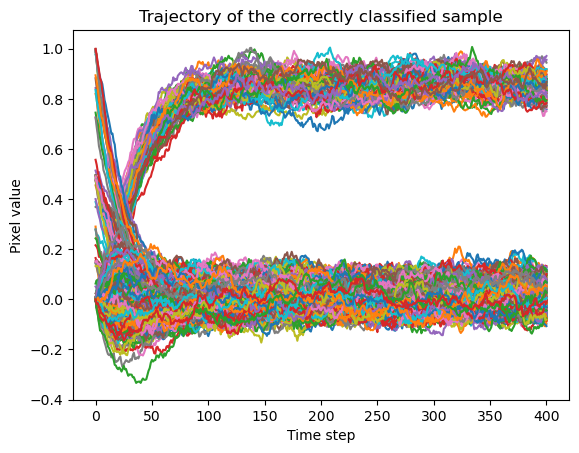

In [32]:
with torch.no_grad(), temporary_attrs(classifier, steps=400, epsilon=0.06):
    for X, y in test_dl:
        X = flatter(X.to(device))
        y = y.to(device)
        pred = classifier(X, story = True)
        correct = ((pred[:, :, None] - classifier.attr[None, :, :]) ** 2).sum(1).argmin(1) == y
        true_indices = torch.where(correct)[0] 

        if len(true_indices) > 0:
            # Randomly pick one index from the True positions
            random_index = true_indices[torch.randint(0, len(true_indices), (1,)).item()]
            break
        else:
            random_index = None 
        
plt.plot(classifier.trajectory[:, random_index, :].cpu())
plt.title("Trajectory of the correctly classified sample")
plt.xlabel("Time step")
plt.ylabel("Pixel value")
plt.show()

Let us repeat the same procedure for the misclassified ones.

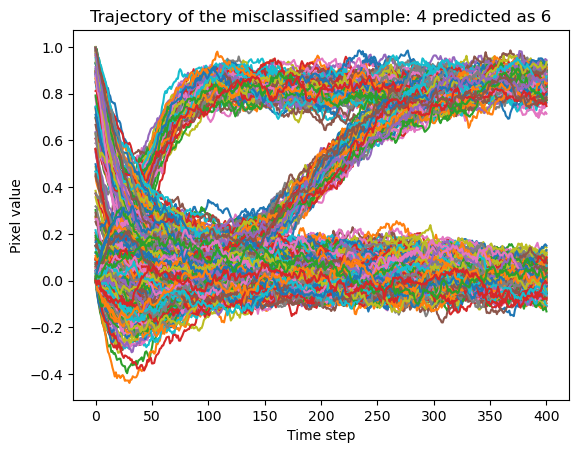

In [60]:
with torch.no_grad(), temporary_attrs(classifier, steps=400, epsilon=0.06):
    for X, y in test_dl:
        X = flatter(X.to(device))
        y = y.to(device)
        pred = classifier(X, story = True)
        predicted_classes = ((pred[:, :, None] - classifier.attr[None, :, :]) ** 2).sum(1).argmin(1)
        incorrect = predicted_classes != y
        false_indices = torch.where(incorrect)[0] 

        if len(false_indices) > 0:
            # Randomly pick one index from the False positions
            random_index = false_indices[torch.randint(0, len(false_indices), (1,)).item()]
            break
        else:
            random_index = None 
        
plt.plot(classifier.trajectory[:, random_index, :].cpu())
plt.title("Trajectory of the misclassified sample: {} predicted as {}".format(y[random_index].item(), predicted_classes[random_index].item()))
plt.xlabel("Time step")
plt.ylabel("Pixel value")
plt.show()